In [111]:
import pandas as pd

In [112]:

df_samsung_train = pd.read_csv(
    "samsung_train.txt",
    sep=r"\s+",
    header=None
)
df_samsung_test = pd.read_csv(
    "samsung_test.txt",
    sep=r"\s+",
    header=None
)
print(df_samsung_train.shape)

(7352, 561)


In [113]:
df_samsung_test.shape

(2947, 561)

In [114]:
print(df_samsung_test.shape[0] + df_samsung_train.shape[0])

10299


## Nie ma sensu danych na test i train, labels tylko do oceny modelu

In [115]:
df_samsung = pd.concat([df_samsung_test, df_samsung_train])

In [116]:
label_train = df_samsung_train = pd.read_csv(
    "samsung_train_labels.txt",
    sep=r"\s+",
    header=None
)
label_test = df_samsung_train = pd.read_csv(
    "samsung_test_labels.txt",
    sep=r"\s+",
    header=None
)

In [117]:
df_labels = pd.concat([label_train, label_test])
df_labels =df_labels.iloc[:, 0]
df_labels.shape

(10299,)

In [118]:
label_names = {
    1:'WALKING',
    2:'WALKING_UPSTAIRS',
    3:'WALKING_DOWNSTAIRS',
    4:'SITTING',
    5:'STANDING',
    6:'LAYING'} # ze strony https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

In [119]:
df_labels_named = df_labels.map(label_names)
df_labels_named.value_counts()

0
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

In [120]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_samsung)

### Redukcja wymiarów

In [121]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=10)
df_pca = pca.fit_transform(df_scaled)

print(df_pca.shape)

(10299, 104)


In [122]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=6,   # wiemy ile jest aktywności
    random_state=10,
    n_init=20
)

clusters = kmeans.fit_predict(df_pca)

In [123]:
from sklearn.metrics import silhouette_score

sil = silhouette_score(df_pca, clusters)
print("Silhouette:", sil)

Silhouette: 0.12355185378604586


In [124]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(df_labels, clusters)
print("ARI:", ari)

ARI: 0.005128302444098102


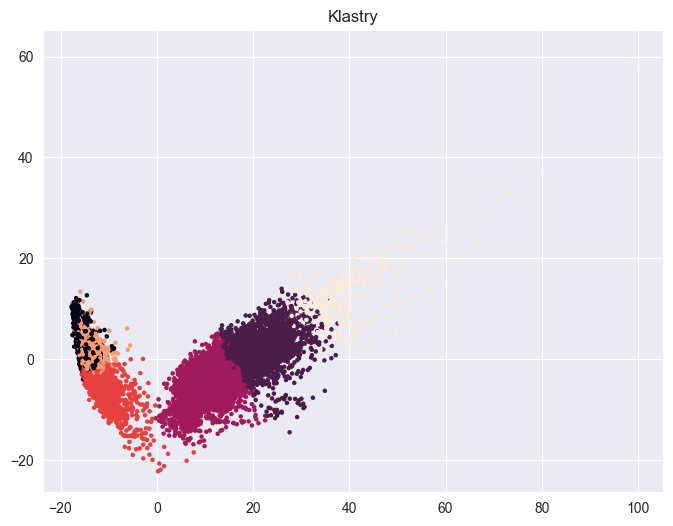

In [125]:
import matplotlib.pyplot as plt

X_2d = PCA(n_components=2).fit_transform(df_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters, s=5)
plt.title("Klastry")
plt.show()

## Inne model

In [126]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
gmm = GaussianMixture(n_components=6, covariance_type='full', random_state=42)
clusters_gmm = gmm.fit_predict(df_pca)

dbscan = DBSCAN(eps=1.5, min_samples=5, metric='euclidean')
clusters_dbscan = dbscan.fit_predict(df_pca)

In [127]:
models = {
    "KMeans": clusters,
    "GMM": clusters_gmm,
    "DBSCAN": clusters_dbscan
}

In [128]:
import numpy as np
for name, clusters in models.items():
    ari = adjusted_rand_score(df_labels, clusters)
    sil = silhouette_score(df_pca, clusters) if len(set(clusters)) > 1 else np.nan
    print(f"{name} - ARI: {ari:.3f}, Silhouette: {sil:.3f}")

KMeans - ARI: 0.005, Silhouette: 0.124
GMM - ARI: 0.005, Silhouette: 0.130
DBSCAN - ARI: 0.000, Silhouette: nan


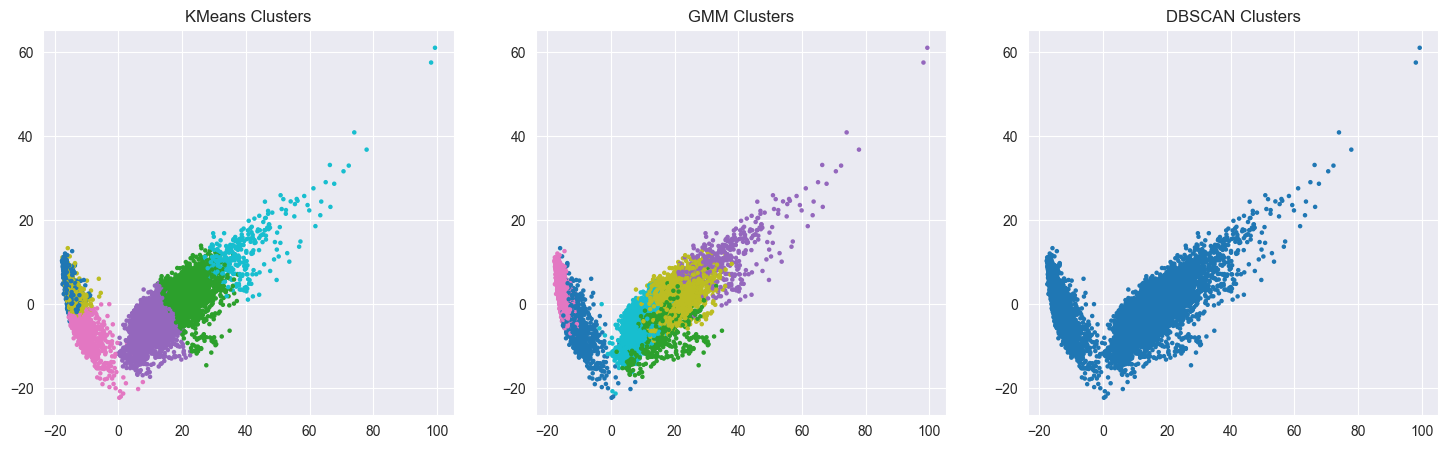

In [129]:
X_2d = PCA(n_components=2, random_state=42).fit_transform(df_scaled)

plt.figure(figsize=(18,5))
for i, (name, clusters) in enumerate(models.items()):
    plt.subplot(1, 3, i+1)
    plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters, s=5, cmap='tab10')
    plt.title(f"{name} Clusters")
plt.show()